# Model description

Using prosumpy (a toolkit for the simulation and economic evaluation of self-consumption and solar home battery systems [1]), we artificially create solar communities. Some functions were modified. Across all the script we use DC-coupled PV-battery systems, without taking into account the DC/DC converter efficiency.

In first place, we create a solar community where there is no trading among the members. Different PV and battery penetration can be used and we evaluate the maximum import/export power to and from the grid at the point of common coupling,  as well as the Self-consumption (SC) and Self-sufficiency (SS) ratios for the whole community and the total community bill (as the sum of the individual bills).

Then, we include into the solar community users preferences in terms of inclination to trade depending on SOC and electricity prices, according to the answers to the survey conducted to 251 house-owners in Germany (March 2020). We then recalculate the same KPI and compare with the previous case to explore the impact of prosumer preferences in P2P communities.

The two models (with and without trading) are implemented in five steps:

1. Household selection, including households with PV, battery and other basis of selection (e.g., environmental awareness, risk aversion)
2. Run (deterministic) dispatch algorithm per household where self-consumption is maximized (in the case with trading, prosumer preferences are included)
3. Run dispatch algorithm for the whole community, using aggregated PV injection and residual demand (in both cases no preferences are applied in this second level and no battery is used). This step allows to know how the electricity will be re-distributed inside the community.
4. Recalculate community flows
5. Calculate KPIs


[1] Quoilin, S. et al., 'Quantifying self-consumption linked to solar home battery systems: Statistical analysis and economic assessment', Applied Energy, Elsevier, 2016, 182, pp. 58-67 (https://github.com/energy-modelling-toolkit/prosumpy))


In [1]:
from functools import partial
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import paper_classes_2 as pc
import Post_processing as pp
import itertools
from functools import wraps
import time
from termcolor import colored
import csv
import os

In [2]:
class bcolors:
    '''Print with colors'''
    HEADER = '\033[95m'
    OKBLUE = '\033[94m'
    OKGREEN = '\033[92m'
    WARNING = '\033[91m'
    FAIL = '\033[91m'
    ENDC = '\033[0m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'

In [3]:
def dict_to_csv(my_dict,filename):
    '''saves the dictionary to a csv using as input the dictionary and the name without the format (.csv)'''
    flag=False
    if os.path.exists(filename+'.csv'):
        flag=True
    with open(filename+'.csv', 'a+') as f:  # Just use 'w' mode in 3.x
        w = csv.writer(f)
        if flag==False:
            w.writerow(my_dict.keys())
        w.writerow(my_dict.values())

In [4]:
def fn_timer(function):
    '''Measures the time a function takes to run'''
    @wraps(function)
    def function_timer(*args, **kwargs):
        t0 = time.time()
        result = function(*args, **kwargs)
        t1 = time.time()
        print ("Total time running %s: %s seconds" %
               (function.__name__, str(t1-t0))
               )
        return result
    return function_timer

In [5]:

def find_interval_PQ(x, partition):
    '''
    Description
    -----------
    find_interval at which x belongs inside partition. Returns the index i.

    Parameters
    ------
    x: float; numerical value
    partition: array; sequence of numerical values
    Returns
    ------
    i: index; index for which applies
    partition[i] < x < partition[i+1], if such an index exists.
    -1 otherwise
    TODO
    ------
    '''
    
    for i in range(0, len(partition)):
        #print(partition)
        if x<partition[1]:
            return 1
        elif x < partition[i]:
            return i-1
        
    return -1

In [6]:
def plot_dispatch(pv, demand, E, week=30):
    """ Visualize dispatch algorithm for a specific week for a single household
    Parameters:
        demand (pd.Series): demand production
        pv (pd.Series): pv production
        E (dict):  Energy flows. Dictionary of pd.Series: res_pv, grid2load, store2inv, LevelOfCharge
    """

    sliced_index = (pv.index.week==week)
    pv_sliced = pv[sliced_index]
    demand_sliced = demand[sliced_index]
    self_consumption = E['inv2load'][sliced_index]
    
    direct_self_consumption = np.minimum(pv_sliced,demand_sliced)# E['inv2load'][sliced_index]
    indirect_self_consumption = self_consumption-direct_self_consumption
    res_pv_sliced = E['res_pv'][sliced_index]
    grid2load_sliced = E['grid2load'][sliced_index]
    store2inv_sliced = E['store2inv'][sliced_index]
    LevelOfCharge = E['LevelOfCharge'][sliced_index]
    inv2grid = E['inv2grid'][sliced_index]
    grid2load = E['grid2load'][sliced_index]
    aux=np.maximum(0,self_consumption)

    fig, axes = plt.subplots(nrows=3, ncols=1, sharex=True, figsize=(17, 4*3), frameon=False,
                             gridspec_kw={'height_ratios': [3, 1, 1], 'hspace': 0.04})

    #fig, ax = plt.subplots(figsize=(17, 4))
    axes[0].plot(demand_sliced.index, demand_sliced, color='black', lw=2,label='demand')
    axes[0].plot(pv_sliced.index, pv_sliced, color='black',ls='--', lw=2,label='PV')
    axes[0].fill_between(direct_self_consumption.index, 0, direct_self_consumption, color='orange', alpha=.8, label='DSC')
    axes[0].fill_between(pv_sliced.index, self_consumption, pv_sliced , where=pv_sliced<demand_sliced,color='blue', hatch='//',
                         alpha=.3,label='ISC')
    axes[0].fill_between(pv_sliced.index, direct_self_consumption, pv_sliced ,where=pv_sliced>demand_sliced, color='gold', alpha=.3,label='Excess PV')

    axes[0].fill_between(grid2load_sliced.index,self_consumption,demand_sliced,color='red',alpha=.2, label='grid2load')
        

    #axes[0].plot(grid2load_sliced.index, grid2load_sliced, color='red', ls=":", lw=1)
    axes[0].set_ylim([0, axes[0].get_ylim()[1] ])
    axes[0].set_ylabel('Power (kW)')

    axes[1].fill_between(LevelOfCharge.index, 0, LevelOfCharge, color='grey', alpha=.2, label='SOC')
    axes[1].set_ylabel('State of Charge (kWh)')

    axes[2].fill_between(inv2grid.index, 0, inv2grid, color='green', alpha=.2,label='injected2grid')
    axes[2].fill_between(inv2grid.index, 0, -grid2load, color='red', alpha=.2,label='grid drawn')
    axes[2].set_ylabel('In/out from grid (kW)')
    axes[0].legend()
    axes[1].legend()
    axes[2].legend()
    return



In [118]:
def plot_dispatch_comm(pv, demand, E, week=30,flag=False,prices=None):
    """ Visualize dispatch algorithm for a specific week for the whole community
    Parameters:
        demand (pd.Series): demand production
        pv (pd.Series): pv production
        E (dict):  Energy flows. Dictionary of pd.Series: res_pv, grid2load, store2inv, LevelOfCharge
        flag (bool): fill_between
    """

    sliced_index = (pv.index.week==week)
    pv_sliced = pv[sliced_index]
    demand_sliced = demand[sliced_index]
    self_consumption = E['inv2load'][sliced_index]
    
    direct_self_consumption = np.minimum(pv_sliced,demand_sliced)# E['inv2load'][sliced_index]
    indirect_self_consumption = self_consumption-direct_self_consumption
    res_pv_sliced = E['res_pv'][sliced_index]
    grid2load_sliced = E['grid2load'][sliced_index]
    store2inv_sliced = E['store2inv'][sliced_index]
    LevelOfCharge = E['LevelOfCharge'][sliced_index]
    inv2grid = E['inv2grid'][sliced_index]
    grid2load = E['grid2load'][sliced_index]
    aux=np.maximum(0,self_consumption)

    fig, axes = plt.subplots(nrows=3, ncols=1, sharex=True, figsize=(17, 4*3), frameon=False,
                             gridspec_kw={'height_ratios': [3, 1, 1], 'hspace': 0.04})

    #fig, ax = plt.subplots(figsize=(17, 4))
    axes[0].plot(demand_sliced.index, demand_sliced, color='black', lw=2,label='demand')
        
    if flag:
        axes[0].plot(pv_sliced.index, pv_sliced, color='green', lw=2,label='pv')
        axes[0].plot(direct_self_consumption.index, direct_self_consumption, color='yellow', lw=2,label='DSC')
        axes[0].plot(indirect_self_consumption.index, indirect_self_consumption, color='orange', lw=2,label='ISC')
        axes[0].plot(grid2load_sliced.index, grid2load_sliced, color='red', lw=2,label='grid')

    else:
        axes[0].fill_between(direct_self_consumption.index, 0, direct_self_consumption, color='orange', alpha=.8, label='DSC')
        axes[0].fill_between(pv_sliced.index, self_consumption, pv_sliced ,where=pv_sliced<demand_sliced, color='blue', hatch='//',
                             alpha=.3,label='ISC')
        axes[0].fill_between(pv_sliced.index, direct_self_consumption, pv_sliced , color='gold', alpha=.3,label='Excess PV')

        axes[0].fill_between(grid2load_sliced.index,self_consumption,demand_sliced,color='red',alpha=.2, label='grid2load')
    
    axes[0].set_ylim([0, axes[0].get_ylim()[1] ])
    axes[0].set_ylabel('Power (kW)')

    axes[1].fill_between(LevelOfCharge.index, 0, LevelOfCharge, color='grey', alpha=.2, label='SOC')
    axes[1].set_ylabel('State of Charge (kWh)')
    if prices is not None:
        ax2 = axes[2].twinx()
        ax2.plot(prices[sliced_index],label='Prices')
        ax2.legend(loc=4)


    axes[2].fill_between(inv2grid.index, 0, inv2grid, color='green', alpha=.2,label='injected2grid')
    axes[2].fill_between(inv2grid.index, 0, -grid2load, color='red', alpha=.2,label='grid drawn')
    axes[2].set_ylabel('In/out from grid (kW)')
    axes[0].set_xlim([grid2load_sliced.index[0],grid2load_sliced.index[-1]])
    axes[0].legend()
    axes[1].legend()
    axes[2].legend()
    return

In [8]:
def print_analysis_prices(pv, demand,retail,export, param, E,isCommunity=False,hh=None):
    """ Print statistics and information of the dispatched solution
    Arguments
        pv (pd.Series): PV timeseries
        demand (pd.Series): demand timeseries
        param (dict): dictionary of technical parameters
        E (dict): dictionary of energy flows as estimated by the algorithm
    Returns
        none
    'store2inv': store2inv, # DC
        'inv2curt':inv2curt # DC
        'pv2store': pv2store, # DC
        'inv2load': inv2load, # AC
        'grid2load': grid2load, # AC
        'pv2inv': pv2inv, # AC
        'LevelOfCharge': LevelOfCharge,
        'inv2grid': inv2grid, #AC
    """
    RemainingSOC=E['LevelOfCharge'][-1]
    timestep = param['timestep']
    SelfConsumption = np.sum(E['inv2load']) * timestep # AC
    TotalFromGrid = np.sum(E['grid2load']) * timestep # AC
    TotalToGrid = np.sum(E['inv2grid']) * timestep # AC
    TotalLoad = demand.sum() * timestep # AC
    #TotalBattToLoad = np.sum(E['store2load']) * timestep # AC
    TotalBattToGrid = np.sum(E['store2grid']) * timestep # AC
    TotalPV = pv.sum() * timestep # DC
    TotalBatteryGeneration = np.sum(E['store2inv']) * timestep # DC
    TotalBatteryConsumption = np.sum(E['pv2store']) * timestep # DC
    if 'inv_losses' in E.keys():
        BatteryLosses=E['batt_losses'].sum()*timestep
        InverterLosses=E['inv_losses'].sum()*timestep
    else:
        BatteryLosses = TotalBatteryConsumption * (1 - param['BatteryEfficiency'])
        InverterLosses = (TotalPV - BatteryLosses-RemainingSOC) * (1 - param['InverterEfficiency'])
    SelfConsumptionRate = SelfConsumption / TotalPV * 100             # in %
    SelfSufficiencyRate = SelfConsumption / TotalLoad * 100
    Bill=((E['grid2load'] * timestep) * retail - (E['inv2grid'] * timestep ) * export).sum()
    Batt_revenue=((E['store2inv']*param['InverterEfficiency']*timestep*retail-
                   E['pv2store']*param['InverterEfficiency']*timestep*export)).sum()
    
    print ('Total yearly consumption: {:1g} kWh'.format(TotalLoad))
    print ('Total PV production: {:1g} kWh'.format(TotalPV))
    print ('Self Consumption: {:1g} kWh'.format(SelfConsumption))
    print ('Total fed to the grid: {:1g} kWh'.format(TotalToGrid))
    print ('Total bought from the grid: {:1g} kWh'.format(TotalFromGrid))
    print ('Self consumption rate (SCR): {:.3g}%'.format(SelfConsumptionRate))
    print ('Self sufficiency rate (SSR): {:.3g}%'.format(SelfSufficiencyRate))
    print ('Amount of energy provided by the battery: {:1g} kWh'.format(TotalBatteryGeneration))
    print ('Total battery losses: {:1g} kWh, i.e., {:1g}% of the total PV'.format(BatteryLosses,BatteryLosses/TotalPV*100))
    #print('Total energy from battery to the load {:1g} kWh'.format(TotalBattToLoad))
    print('Total energy from battery to the grid {:1g} kWh'.format(TotalBattToGrid))
    #print ('Total inverter losses: {:1g} kWh'.format(InverterLosses))
    #print ('Total inverter losses: {:1g} kWh'.format(InverterLosses))
    print ('Total inverter losses: {:1g} kWh, i.e., {:1g}% of the total PV'.format(InverterLosses,InverterLosses/TotalPV*100))
    
    
    TotalCurtailment=np.sum(E['inv2curt'])*timestep # DC
    print ('Total curtailment : {:1g} kWh'.format(TotalCurtailment))    
    residue = TotalPV + TotalFromGrid - TotalToGrid - BatteryLosses - InverterLosses - TotalLoad - TotalCurtailment - RemainingSOC
    print ('Residue (check): {:1g} kWh'.format(residue))
    PV_check = TotalPV - SelfConsumption - TotalToGrid - BatteryLosses - InverterLosses - TotalCurtailment - RemainingSOC
    print ('PV Residue (check): {:1g} kWh'.format(PV_check))
    
    print(bcolors.WARNING + 'Maximum power injected into the grid is {:1g} kW'.format(E['inv2grid'].max())+bcolors.ENDC)
    print(bcolors.WARNING + 'Maximum power drained from the grid is {:1g} kW'.format(E['grid2load'].max())+bcolors.ENDC)
    print (bcolors.WARNING + 'Total bill: {:1g}\n\n'.format(Bill)+bcolors.ENDC)
    print (bcolors.WARNING + 'Total Batt_revenue: {:1g}\n\n'.format(Batt_revenue)+bcolors.ENDC)
    
    if isCommunity==False:
        AverageDepth = TotalBatteryGeneration / (365 * param['BatteryCapacity'])
        Nfullcycles = 365 * AverageDepth        
        print ('Number of equivalent full cycles per year: {:1g} '.format(Nfullcycles))
        print ('Average Charging/Discharging depth: {:1g}\n\n'.format(AverageDepth))
        
        out = { 'SCR': SelfConsumptionRate, # 
                'SSR':SelfSufficiencyRate, # 
                'EFC': Nfullcycles, # 
                'Demand_peak': E['grid2load'].max(), # 
                'Inj_peak': E['inv2grid'].max(), #
                'avg_dod': AverageDepth, #
                'bill': Bill,
                'Batt_revenue':Batt_revenue,
                'Batt_penetration':param['batt_penetration'],
                'PV_penetration':param['pv_penetration'],
                'seed':param['seed'],
                'hh':hh
                }
    else:
        out = { 'SCR': SelfConsumptionRate, # 
                'SSR':SelfSufficiencyRate, # 
                'EFC': None, # 
                'Demand_peak': E['grid2load'].max(), # 
                'Inj_peak': E['inv2grid'].max(), #
                'avg_dod': None, #
                'bill': Bill,
                'Batt_revenue':Batt_revenue,
                'Batt_penetration':param['batt_penetration'],
                'PV_penetration':param['pv_penetration'],
                'seed':param['seed'],
                'hh':hh
                }
    return out

In [9]:
def dispatch_max_sc(pv, demand, inv_size,param, return_series=False):
    """ Self consumption maximization pv + battery dispatch algorithm.
    The dispatch of the storage capacity is performed in such a way to maximize self-consumption:
    the battery is charged when the PV power is higher than the load and as long as it is not fully charged.
    It is discharged as soon as the PV power is lower than the load and as long as it is not fully discharged.
    Arguments:
        pv (pd.Series): Vector of PV generation, in kW DC (i.e. before the inverter)
        demand (pd.Series): Vector of household consumption, kW
        param (dict): Dictionary with the simulation parameters:
                timestep (float): Simulation time step (in hours)
                BatteryCapacity: Available battery capacity (i.e. only the the available DOD), kWh
                BatteryEfficiency: Battery round-trip efficiency, -
                InverterEfficiency: Inverter efficiency, -
                MaxPower: Maximum battery charging or discharging powers (assumed to be equal), kW
        return_series(bool): if True then the return will be a dictionary of series. Otherwise it will be a dictionary of ndarrays.
                        It is reccommended to return ndarrays if speed is an issue (e.g. for batch runs).
    Returns:
        dict: Dictionary of Time series
    """
    bat_size_e_adj = param['BatteryCapacity']
    bat_size_p_adj = param['MaxPower']
    n_bat = param['BatteryEfficiency']
    n_inv = param['InverterEfficiency']
    timestep = param['timestep']
    # We work with np.ndarrays as they are much faster than pd.Series
    Nsteps = len(pv)
    LevelOfCharge = np.zeros(Nsteps)
    #inv2grid = np.zeros(Nsteps)
    inv_array=np.tile(inv_size/n_inv,len(pv))
    pv2store = np.zeros(Nsteps)
    store2inv = np.zeros(Nsteps)
    inv2curt = np.zeros(Nsteps)
    flagsell = np.zeros(Nsteps)
    flag_12h = np.zeros(Nsteps)
    store2grid = np.zeros(Nsteps)
    store2load = np.zeros(Nsteps)
    #grid2store = np.zeros(Nsteps) # TODO Always zero for now.

    #Load served by PV
    pv2load_dc = np.array([pv, demand / n_inv,inv_array]).min(axis=0)  # DC direct self-consumption, with inverter limitation

    #Residual load
    res_load = demand - (pv2load_dc * n_inv)  # AC
    inv2load = pv2load_dc * n_inv  # AC

    #Excess PV
    res_pv = pv-pv2load_dc # DC

    #PV to storage after eff losses
    pv2inv = pv2load_dc*n_inv # AC

    #first timestep = 0
    LevelOfCharge[0] = 0  # bat_size_e_adj / 2  # DC


    for i in range(1,Nsteps):
        #PV to storage
        if LevelOfCharge[i-1] >= bat_size_e_adj:  # if battery is full
                pv2store[i] = 0
        else: #if battery is not full

            if LevelOfCharge[i-1] + res_pv[i] * n_bat * timestep > bat_size_e_adj:  # if battery will be full after putting excess
                pv2store[i] = min((bat_size_e_adj - LevelOfCharge[i-1]) / timestep, bat_size_p_adj)
            else:
    #                pv2store[i] = min(res_pv[i], bat_size_p_adj)
                pv2store[i] = min(res_pv[i] * n_bat, bat_size_p_adj)
        #Storage to load
        if pv2store[i]==0:# modification to original algorithm (The battery cannot charge and discharge at the same time)
            store2inv[i] = min(bat_size_p_adj,(inv_size/n_inv-pv2load_dc[i]),  # DC
                       res_load[i] / n_inv,
                       LevelOfCharge[i-1] / timestep) #modif to original, store2inv=pv2store*n_bat

        #SOC
        LevelOfCharge[i] = min(LevelOfCharge[i-1] - (store2inv[i] - pv2store[i]*n_bat ) * timestep,  # DC
                               bat_size_e_adj)#modif to original, store2inv=pv2store*n_bat

    pv2grid_dc=np.array([pv-pv2store,inv_array]).min(axis=0)-pv2load_dc # DC
    pv2inv= (pv2grid_dc+pv2load_dc)*n_inv # AC
    inv2curt=pv-pv2grid_dc-pv2load_dc-pv2store # DC

    inv2load = (pv2load_dc + store2inv) * n_inv  # AC
    inv2grid = pv2grid_dc * n_inv  # AC
    grid2load = demand - inv2load  # AC
    #MaxDischarge = np.minimum(LevelOfCharge[i-1]*BatteryEfficiency/timestep,MaxPower)
    batt_losses=pv2store*(1-n_bat)
    inv_losses=(pv2grid_dc+pv2load_dc+store2inv)*(1-n_inv)
    #Potential Grid to storage  # TODO: not an option for now in this strategy
    # GridPurchase = False
    
    out = { 'pv2inv': pv2inv, # AC
            'res_pv':res_pv, # DC
            'pv2store': pv2store, # DC
            'inv2load': inv2load, # AC
            'grid2load': grid2load, # AC
            'store2inv': store2inv, # DC
            'inv2curt':inv2curt, # DC
            'LevelOfCharge': LevelOfCharge, # kWh
            'inv2grid': inv2grid, #AC            
            'inv_losses':inv_losses,
            'batt_losses':batt_losses,
            'flag_sell':flagsell,
            'flag_12h':flag_12h,             
            'store2grid':store2grid,
            'store2load':store2inv*n_inv # DC
            }
    if not return_series:
        out_pd = {}
        for k, v in out.items():  # Create dictionary of pandas series with same index as the input pv
            out_pd[k] = pd.Series(v, index=pv.index)
        out = out_pd
    return out

In [10]:
@fn_timer
def flag_selection(df,list_product,list_pv_penetration,list_batt_penetration,community_size,seed):
    '''
    Function that randomly selects the households that will have PV only and those with PV and battery
    ''' 
    np.random.seed(seed)
    list_names=['sub_'+str(i[0])+'_'+str(i[1]) for i in list_product]
    for i in list_names:
        df[i]=False
    dict_pv_df={}
    dict_batt_df={}
    j=0
    l=0
    for i in list_pv_penetration: 
        #print('-----')
        dict_pv_df[j]=np.random.choice(df.index,int(len(df)*(i/100)), replace=False)
        for k in list_batt_penetration:
            #print(int(len(dict_pv_df[j])*(k/100)))
            dict_batt_df[l]=np.random.choice(dict_pv_df[j],int(len(dict_pv_df[j])*(k/100)), replace=False)
            df.iloc[dict_batt_df[l],l+2]=True
            l+=1
        j+=1
    return df

In [11]:
import pickle
def save_obj(obj, name ):
    with open('../Output/'+name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def load_obj(name ):
    with open('../Output/' + name + '.pkl', 'rb') as f:
        return pickle.load(f)

# Part I. Creation of the Solar community without trading

## 1. Household selection (data in kW)

If it is the first time you run this script set first_time to True (to select randomly the demand profiles and the PV sizes), otherwise set it to False

In [12]:
first_time=True
community_size=50
timestep=0.25 # in hours 0.25 is 15 minutes
seed=1

In [13]:
df_CH=pd.read_csv('../Input/df_CH_Marzia3.csv', encoding='utf8', sep=',',usecols=[*range(0, 669)],
                              engine='python',date_parser=lambda col: pd.to_datetime(col, utc=True),infer_datetime_format=True,index_col=0)
df_CH.index=df_CH.index.tz_convert('Europe/Brussels')
if timestep==1:
    df_CH=df_CH.resample('1H').sum()
else:
    df_CH_kW=df_CH/timestep #data must be in kW
max_PV=10
if first_time:   
    path='../Input/'
    df_pv_ch=pd.read_excel(path+'PV_beneficiaires_Swiss.xlsx')
    df_nat=df_pv_ch[(df_pv_ch['Anlage_Projekt-Bezeichnung']=='natürliche Person')]
    df_nat_pv=df_nat[(df_nat['Anlage_Energieträger']=='Photovoltaik')]
    df_nat_pv_15=df_nat_pv[df_nat_pv['Leistung [kW]']<max_PV]['Leistung [kW]'].reset_index(drop=True)

df_CH contains 667 demand profiles for 2017 (CREM is for 2015, but this dataset was updated to match 2017). The last column is E_PV which includes the PV generation for 1 kW system in Geneva for 2017. The community will be done selecting 100 out of the 667 profiles. We select only those profiles with a consumption below 7500 kWh per year (647)

The PV distribution contains more than 20000 points, we randomly select 100 (lower than 10 kW).

In [14]:
df=pd.DataFrame(df_CH_kW.loc[:,(df_CH_kW.sum()<(7500/timestep))&(df_CH_kW.columns!='E_PV')].sample(n=community_size,axis=1).columns)
if first_time:
    #df=pd.DataFrame(df_CH.loc[:,(df_CH.sum()<7500)&(df_CH.columns!='E_PV')].sample(n=community_size,axis=1).columns)
    selection=pd.concat([df_nat_pv_15.round(1).sample(n=community_size,random_state=1).reset_index(drop=True),df],axis=1)
    selection.columns=['PV_size','name']
    list_pv_penetration=[100,75,50,25]# %
    list_batt_penetration=[100,75,50,25]# %
    list_product=list(itertools.product(list_pv_penetration,list_batt_penetration))
    selection=flag_selection(selection,list_product,list_pv_penetration,list_batt_penetration,community_size,seed)
    print(selection.sum())
    selection.to_csv('../Input/selection.csv',index=False)
    first_time=False

Total time running flag_selection: 0.011052608489990234 seconds
PV_size        246.4
name             inf
sub_100_100     50.0
sub_100_75      37.0
sub_100_50      25.0
sub_100_25      12.0
sub_75_100      37.0
sub_75_75       27.0
sub_75_50       18.0
sub_75_25        9.0
sub_50_100      25.0
sub_50_75       18.0
sub_50_50       12.0
sub_50_25        6.0
sub_25_100      12.0
sub_25_75        9.0
sub_25_50        6.0
sub_25_25        3.0
dtype: float64


In [15]:
if not first_time:
    selection=pd.read_csv('../Input/selection.csv')


We define the battery parameters (NMC-based) as well as the Inverter efficiency (when only PV is used)

In [16]:
pv_penetration=50
batt_penetration=50
#ILR=1.2

In [17]:
community_size

50

In [18]:
param_tech = {'BatteryCapacity': 10,
              'BatteryEfficiency': .91,
              'InverterEfficiency': .94,
              'timestep': timestep,
              'MaxPower': 4,
              'pv_penetration':pv_penetration,
              'batt_penetration':batt_penetration,
              'seed':seed,
              'community_size':community_size
             }
param_tech_no_batt = {'BatteryCapacity': 0,
              'BatteryEfficiency': .91,
              'InverterEfficiency': .94,
              'timestep': timestep,
              'MaxPower': 0,
              'pv_penetration':pv_penetration,
              'batt_penetration':batt_penetration,
              'seed':seed,
              'community_size':community_size        
             }
param_tech_comm = {'BatteryCapacity': 0,
              'BatteryEfficiency': 1,
              'InverterEfficiency': 1,
              'timestep': timestep,
              'MaxPower': 0,
              'pv_penetration':pv_penetration,
              'batt_penetration':batt_penetration,
              'seed':seed,
              'community_size':community_size
             }

Select the PV and battery penetration. In this model there is no battery export.


Battery penetration w.r.t. the amount of PV installed. i.e., if 50 households out of 100 have PV, 50% battery penetration means that 25 households out of the 50 with PV have a 10 kWh battery.

## 2. Run the dispatch algorithm for every household

We iterate through the community and get the dispatching for the PV and battery for every household



In [19]:
nested_out={}
j=0
k=0
PV_size_comm=0
for i in selection.index:
    print(i, end='')
    if selection.loc[i,'sub_'+str(pv_penetration)+'_100']:#all with PV
        inv_size=max(param_tech['MaxPower'],selection.PV_size[i])#selection.PV_size[i]/ILR
        PV_size_comm+=selection.PV_size[i]
        if selection.loc[i,'sub_'+str(pv_penetration)+'_'+str(batt_penetration)]: #if battery
            nested_out[i]=dispatch_max_sc(df_CH_kW.E_PV*selection.PV_size[i],df_CH_kW.loc[:,str(selection.name[i])],inv_size,param_tech)
            j+=1
        else: #if only PV battery=0 kWh
            nested_out[i]=dispatch_max_sc(df_CH_kW.E_PV*selection.PV_size[i],df_CH_kW.loc[:,str(selection.name[i])],inv_size,param_tech_no_batt)
            k+=1
    else: #No PV
        nested_out[i]=dispatch_max_sc(df_CH_kW.E_PV*0,df_CH_kW.loc[:,str(selection.name[i])],0,param_tech_no_batt)
    

012345678910111213141516171819202122232425262728293031323334353637383940414243444546474849

The data from the community is aggregated in a single dictionary

Save everything in a separated class it would be easier to calculate afterwards?

In [20]:
#get all the data in a single dict
pv2inv=pd.DataFrame()
res_pv=pd.DataFrame()
pv2store=pd.DataFrame()
inv2load=pd.DataFrame()
grid2load=pd.DataFrame()
store2inv=pd.DataFrame()
inv2curt=pd.DataFrame()
LevelOfCharge=pd.DataFrame()
inv2grid=pd.DataFrame()
batt_losses=pd.DataFrame()
inv_losses=pd.DataFrame()
store2load=pd.DataFrame()
store2grid=pd.DataFrame()
for i in nested_out.keys():
    pv2inv['pv2inv'+str(i)]=nested_out[i]['pv2inv']
    inv2curt['inv2curt'+str(i)]=nested_out[i]['inv2curt']
    pv2store['pv2store'+str(i)]=nested_out[i]['pv2store']
    inv2load['inv2load'+str(i)]=nested_out[i]['inv2load']
    batt_losses['batt_losses'+str(i)]=nested_out[i]['batt_losses']
    inv_losses['inv_losses'+str(i)]=nested_out[i]['inv_losses']
    store2inv['store2inv'+str(i)]=nested_out[i]['store2inv']
    LevelOfCharge['LevelOfCharge'+str(i)]=nested_out[i]['LevelOfCharge']
    res_pv['res_pv'+str(i)]=nested_out[i]['res_pv']#not important, recalculated later
    inv2grid['inv2grid'+str(i)]=nested_out[i]['inv2grid']#not important, recalculated later
    grid2load['grid2load'+str(i)]=nested_out[i]['grid2load']#not important, recalculated later
    store2load['store2load'+str(i)]=nested_out[i]['store2load']
    store2grid['store2grid'+str(i)]=nested_out[i]['store2grid']
nested_dict={'pv2inv':pv2inv.sum(axis=1),'pv2store':pv2store.sum(axis=1),'inv2load':inv2load.sum(axis=1),
             'grid2load':grid2load.sum(axis=1),'store2inv':store2inv.sum(axis=1),'LevelOfCharge':LevelOfCharge.sum(axis=1),
             'inv2grid':inv2grid.sum(axis=1),'res_pv':res_pv.sum(axis=1),'store2grid':store2grid.sum(axis=1),
             'store2load':store2load.sum(axis=1),'inv_losses':inv_losses.sum(axis=1),
             'batt_losses':batt_losses.sum(axis=1),'inv2curt':inv2curt.sum(axis=1)}

In [21]:
nested_out.keys()

dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49])

Now calculate how the excess of PV will be absorbed in the remaining load of the community (all households without batteries)

## 3. Run the dispatch algorithm for the whole community

Using aggregated PV injection and residual demand

Use very big inverter (not existing for this)

In [22]:
out_comm_res=dispatch_max_sc(nested_dict['inv2grid'],nested_dict['grid2load'],1e10,param_tech_comm)

## 4. Calculate community energy flows

Finally, we create the dictionary combining the results from the households with PV, PV and battery and without PV or battery.

When we calculate the community energy flows we take the injection into the grid as production (PV Only here, after inverter curtailment) and the initial load demand as the community demand (the demand in the houses with PV panels that export is 0 at that point).

Demand locally covered by the community: inv2load is then the sum of the demand covered by the PV-coupled battery systems or PV systems in every house (nested_dict['inv2load']) and the demand covered by the PV export inside the community (out_comm_res['inv2load'])





In [23]:
out_comm_final={}
out_comm_final['pv2inv']=nested_dict['pv2inv'] # DC from hh with PV
out_comm_final['pv2store']=nested_dict['pv2store'] # DC PV 2 batt from hh with PV
out_comm_final['inv2load']=(nested_dict['inv2load']+out_comm_res['inv2load']) # AC from all hh
out_comm_final['store2inv']=nested_dict['store2inv'] # DC  from hh with PV and batt
out_comm_final['LevelOfCharge']=nested_dict['LevelOfCharge'] # kWh  from hh with PV and batt
out_comm_final['res_pv']=out_comm_res['res_pv'] # DC  from hh with PV
out_comm_final['inv2grid']=out_comm_res['inv2grid'] # AC from hh with PV
out_comm_final['grid2load']=out_comm_res['grid2load'] # AC  from all hh
out_comm_final['inv2curt']=nested_dict['inv2curt'] # DC  from hh with PV
out_comm_final['batt_losses']=nested_dict['batt_losses']
out_comm_final['inv_losses']=nested_dict['inv_losses']
out_comm_final['store2load']=nested_dict['store2load']
out_comm_final['store2grid']=nested_dict['store2grid']
out_comm_final['LevelOfCharge']=nested_dict['LevelOfCharge']
out_comm_final['PV_size_comm']=PV_size_comm
out_comm_final['df']=df_CH
out_comm_final['param_tech']=param_tech
out_comm_final['nested_dict']=nested_dict
out_comm_final['selection']=selection



## 5. Calculate KPIs

Run the analysis of the community with the PV size equals to the sum of all PV sizes and with the aggregated demand

In [24]:
retail_price_sc=np.ones(pv2inv.shape[0])*0.29
export_price_sc=np.ones(pv2inv.shape[0])*0.04

In [25]:
out=print_analysis_prices(df_CH_kW.E_PV*PV_size_comm, df_CH_kW.loc[:,df.iloc[:,0]].sum(axis=1),retail_price_sc,export_price_sc,
                      param_tech_comm,out_comm_final,isCommunity=True)


Total yearly consumption: 121732 kWh
Total PV production: 155303 kWh
Self Consumption: 55008 kWh
Total fed to the grid: 88744.8 kWh
Total bought from the grid: 66724.2 kWh
Self consumption rate (SCR): 35.4%
Self sufficiency rate (SSR): 45.2%
Amount of energy provided by the battery: 13048.7 kWh
Total battery losses: 1292.76 kWh, i.e., 0.832407% of the total PV
Total energy from battery to the grid 0 kWh
Total inverter losses: 9175.71 kWh, i.e., 5.90825% of the total PV
Total curtailment : 1059.62 kWh
Residue (check): 3.48876e-11 kWh
PV Residue (check): 2.21547e-11 kWh
Maximum power injected into the grid is 102.439 kW
Maximum power drained from the grid is 41.28 kW
Total bill: 15800.2


Total Batt_revenue: 3209.56




In [26]:
out.keys()

dict_keys(['SCR', 'SSR', 'EFC', 'Demand_peak', 'Inj_peak', 'avg_dod', 'bill', 'Batt_revenue', 'Batt_penetration', 'PV_penetration', 'seed', 'hh'])

In [27]:
#dict_to_csv(out,'../Output/test1')

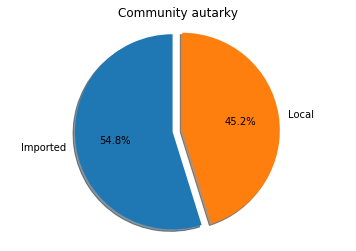

In [28]:
labels = 'Imported', 'Local'
sizes = [out_comm_final['grid2load'].sum()*param_tech_comm['timestep'], out_comm_final['inv2load'].sum()*param_tech_comm['timestep']]
explode = (0, 0.1)  # only "explode" the 2nd slice (i.e. 'Hogs')

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
ax1.set_title('Community autarky')
plt.show()

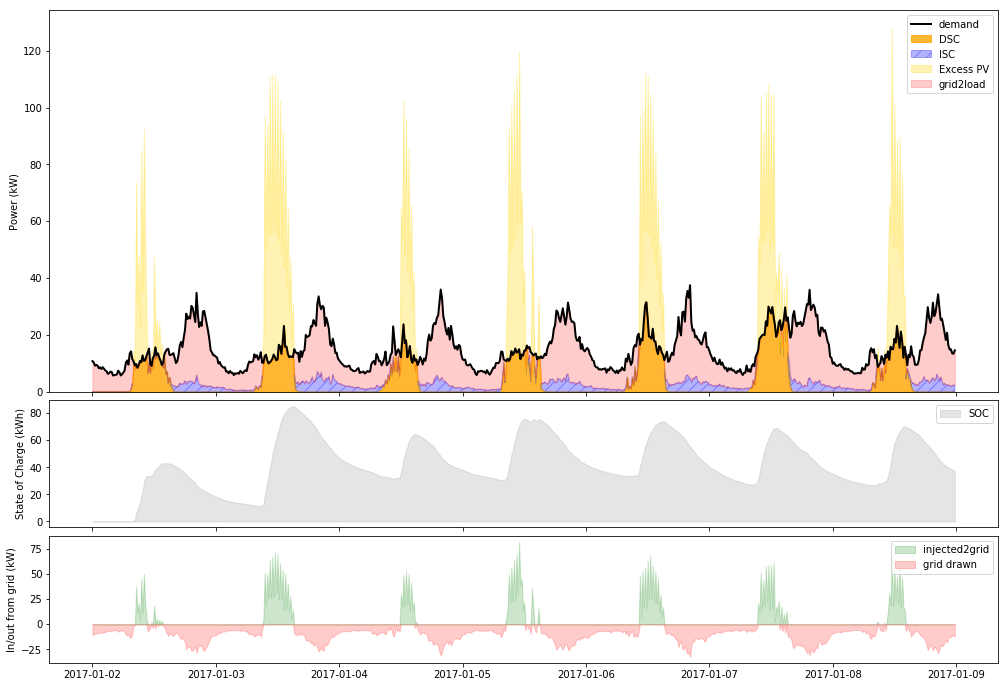

In [81]:
plot_dispatch_comm(df_CH_kW.E_PV*PV_size_comm, df_CH_kW.loc[:,df.iloc[:,0]].sum(axis=1),out_comm_final, week=1,flag=0)

In [30]:
#plot_dispatch_comm(df_CH_kW.E_PV*PV_size_comm, df_CH_kW.loc[:,df.iloc[:,0]].sum(axis=1),out_comm_final, week=1,flag=1)

Total yearly consumption: 2081.58 kWh
Total PV production: 6161.72 kWh
Self Consumption: 1744.84 kWh
Total fed to the grid: 3908.21 kWh
Total bought from the grid: 336.744 kWh
Self consumption rate (SCR): 28.3%
Self sufficiency rate (SSR): 83.8%
Amount of energy provided by the battery: 994.112 kWh
Total battery losses: 98.3188 kWh, i.e., 1.59564% of the total PV
Total energy from battery to the grid 0 kWh
Total inverter losses: 360.833 kWh, i.e., 5.85603% of the total PV
Total curtailment : 49.5277 kWh
Residue (check): -2.84217e-12 kWh
PV Residue (check): -3.35376e-12 kWh
Maximum power injected into the grid is 4.4 kW
Maximum power drained from the grid is 3.84 kW
Total bill: -58.6726


Total Batt_revenue: 229.919




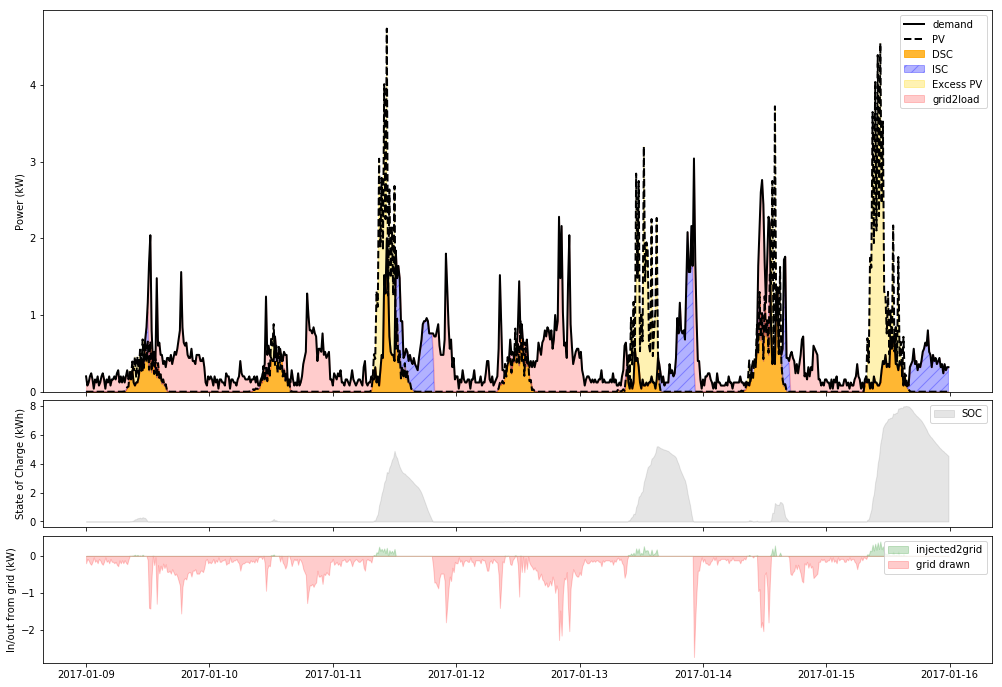

In [31]:
# Single household test
hhNumber=20
inv_size=max(selection.PV_size[hhNumber],param_tech['MaxPower'])
out_aux=dispatch_max_sc(df_CH_kW.E_PV*selection.PV_size[hhNumber],df_CH_kW.loc[:,str(selection.name[hhNumber])],
                        inv_size,param_tech)

out_aux.keys()

(out_aux['pv2store']-out_aux['store2inv']).sum()*timestep

selection.PV_size[hhNumber]

print_analysis_prices(df_CH_kW.E_PV*selection.PV_size[hhNumber],df_CH_kW.loc[:,str(selection.name[hhNumber])],retail_price_sc,
                      export_price_sc,param_tech,out_aux,hhNumber)

plot_dispatch(df_CH_kW.E_PV*selection.PV_size[hhNumber],df_CH_kW.loc[:,str(selection.name[hhNumber])],out_aux,week=2)

# --------------------------------------------------------------------------------------------------

# Part II. Solar communities with P2P trading and prosumer behaviour

In [32]:
import datetime as dt
import warnings
warnings.filterwarnings('error')

In [33]:
def dispatch_max_sc_bhv(pv, demand, bhv,prices_binned,inv_size,param , return_series=False, bins_soc=[0,33,66,100],bins_price=[0.04,0.12,0.20,0.28],kW_dis=4):
    """ Self consumption maximization pv + battery dispatch algorithm.
    The dispatch of the storage capacity is performed in such a way to maximize self-consumption:
    the battery is charged when the PV power is higher than the load and as long as it is not fully charged.
    It is discharged as soon as the PV power is lower than the load and as long as it is not fully discharged.
    Arguments:
        pv (pd.Series): Vector of PV generation, in kW DC (i.e. before the inverter)
        demand (pd.Series): Vector of household consumption, kW
        param (dict): Dictionary with the simulation parameters:
                timestep (float): Simulation time step (in hours)
                BatteryCapacity: Available battery capacity (i.e. only the the available DOD), kWh
                BatteryEfficiency: Battery round-trip efficiency, -
                InverterEfficiency: Inverter efficiency, -
                MaxPower: Maximum battery charging or discharging powers (assumed to be equal), kW
                prices: Community prices for sell and buy
        bhv (pd.DataFrame): pd.DataFrame with price, SOC, surplus time for sell and willingness to participate in the community
        return_series(bool): if True then the return will be a dictionary of series. Otherwise it will be a dictionary of ndarrays.
                        It is reccommended to return ndarrays if speed is an issue (e.g. for batch runs).
    Returns:
        dict: Dictionary of Time series
    """
    
    bat_size_e_adj = param['BatteryCapacity']
    bat_size_p_adj = param['MaxPower']
    n_bat = param['BatteryEfficiency']
    n_inv = param['InverterEfficiency']
    timestep = param['timestep']
    # We work with np.ndarrays as they are much faster than pd.Series
    Nsteps = len(pv)
    LevelOfCharge = np.zeros(Nsteps)
    inv2grid = np.zeros(Nsteps)
    inv_array=np.tile(inv_size/n_inv,len(pv))
    pv2store = np.zeros(Nsteps)
    store2inv = np.zeros(Nsteps)
    inv2curt = np.zeros(Nsteps)
    
    flagsell = np.zeros(Nsteps)
    store2load = np.zeros(Nsteps)
    store2grid = np.zeros(Nsteps)
    flag_12h=np.full((Nsteps), False)
    #grid2store = np.zeros(Nsteps) # TODO Always zero for now.
    
    #Load served by PV
    pv2load_dc = np.array([pv, demand / n_inv,inv_array]).min(axis=0)  # DC direct self-consumption, with inverter limitation

    #Residual load
    res_load = demand - (pv2load_dc * n_inv)  # AC
    inv2load = pv2load_dc * n_inv  # AC

    #Excess PV
    res_pv = pv-pv2load_dc # DC

    #PV to storage after eff losses
    pv2inv = pv2load_dc*n_inv # AC

    #first timestep = 0
    LevelOfCharge[0] = 0  # bat_size_e_adj / 2  # DC

    #get the sp hours
    delta=dt.timedelta(hours=12)
    sp_hour=res_pv.ne(0).groupby([res_pv.index.month,res_pv.index.day]).idxmax().droplevel(1).reset_index(drop=True)
    twelve_bf=sp_hour-delta

    for i in range(1,Nsteps):    
        #PV to storage
        if LevelOfCharge[i-1] >= bat_size_e_adj:  # if battery is full
                pv2store[i] = 0
        else: #if battery is not full
            if LevelOfCharge[i-1] + res_pv[i] * n_bat * timestep > bat_size_e_adj:  # if battery will be full after putting excess
                pv2store[i] = min((bat_size_e_adj - LevelOfCharge[i-1]) / timestep, bat_size_p_adj)
            else:
#                pv2store[i] = min(res_pv[i], bat_size_p_adj)
                pv2store[i] = min(res_pv[i] * n_bat, bat_size_p_adj)
        #Storage to load
        if (pv2store[i]==0)&(res_pv[i]==0): 
            #According to prosumer behaviour the battery will inject into the community or not only if there is not PV suplus
            store2load[i] = min(bat_size_p_adj,(inv_size/n_inv-pv2load_dc[i]), #Power
                           res_load[i] / n_inv, #Power
                           LevelOfCharge[i-1] / timestep)  # Power; all in DC
            if (pv.index[i]<=sp_hour[int(np.floor((i)/24*timestep))]) & (pv.index[i]>twelve_bf[int(np.floor((i)/24*timestep))]):
                #if timestep is between twelve hours before and the surplus hour
                try:
                    flag_12h[i]=True
                    if np.array(bhv.loc[(bhv.Price_binned==prices_binned[i])&
                                        (bhv.SOC_binned==np.digitize(LevelOfCharge[i-1],bins=bins_soc))&
                                        (bhv.surplus_time=='12h'),'sell'].values):#if sell
                        #surplus_time==12h
                        # sell 1 kWh of energy to the community and cover residual load if excess
                        #print('12hsell')
                        flagsell[i]=1
                        store2grid[i] = min(bat_size_p_adj-store2load[i],(inv_size/n_inv-pv2load_dc[i]-store2load[i]),  #Power
                                               kW_dis / n_inv, #Power
                                               (LevelOfCharge[i-1]) / timestep-store2load[i])# Power; all in DC
                        store2inv[i] = (store2load[i]+store2grid[i]) # DC

                    # here should take into account whether the prosumer desires to sell or not according to his preferences (SOC,price)
                    else: # no sell then cover only res_load
                        #print('out12h')
                        store2inv[i] = (store2load[i]+store2grid[i]) #DC
                except Exception as e:
                    # Ugly but provisional SOC bin from 0 to 1
                    if np.array(bhv.loc[(bhv.Price_binned==prices_binned[i])&
                                        (bhv.SOC_binned==1)&
                                        (bhv.surplus_time=='12h'),'sell'].values):#if sell
                        #surplus_time==12h
                        # sell 1 kWh of energy to the community and cover residual load if excess
                        #print('12hsell')
                        flagsell[i]=1
                        store2grid[i] = min(bat_size_p_adj-store2load[i],(inv_size/n_inv-pv2load_dc[i]-store2load[i]),  #Power
                                               kW_dis / n_inv, #Power
                                               (LevelOfCharge[i-1]) / timestep-store2load[i])# Power; all in DC
                        store2inv[i] = (store2load[i]+store2grid[i]) # DC
                    else: # no sell then cover only res_load
                        #print('out12h')
                        store2inv[i] = (store2load[i]+store2grid[i]) #DC
                    
            else: 
                try:
                
                    if np.array(bhv.loc[(bhv.Price_binned==prices_binned[i])&
                                        (bhv.SOC_binned==np.digitize(LevelOfCharge[i-1],bins=bins_soc))&
                                        (bhv.surplus_time=='12h+'),'sell'].values):#if sell
                        #surplus_time==12h+
                        # sell 1 kWh of energy to the community and cover residual load if excess                    
                        flagsell[i]=2
                        store2grid[i] = min(bat_size_p_adj-store2load[i],(inv_size/n_inv-pv2load_dc[i]-store2load[i]),  #Power
                                               kW_dis / n_inv, #Power
                                               (LevelOfCharge[i-1]) / timestep-store2load[i])# Power; all in DC
                        store2inv[i] = (store2load[i]+store2grid[i]) # DC

                    # here should take into account whether the prosumer desires to sell or not according to his preferences (SOC,price)
                    else: # no sell then cover only res_load
                        #print('out12h+')
                        store2inv[i] = (store2load[i]+store2grid[i]) #DC
                except Exception as e:
                    # Ugly but provisional SOC bin from 0 to 1
                    if np.array(bhv.loc[(bhv.Price_binned==prices_binned[i])&
                                        (bhv.SOC_binned==1)&
                                        (bhv.surplus_time=='12h+'),'sell'].values):#if sell
                        #surplus_time==12h
                        # sell 1 kWh of energy to the community and cover residual load if excess
                        #print('12hsell')
                        flagsell[i]=1
                        store2grid[i] = min(bat_size_p_adj-store2load[i],(inv_size/n_inv-pv2load_dc[i]-store2load[i]),  #Power
                                               kW_dis / n_inv, #Power
                                               (LevelOfCharge[i-1]) / timestep-store2load[i])# Power; all in DC
                        store2inv[i] = (store2load[i]+store2grid[i]) # DC
                    else: # no sell then cover only res_load
                        #print('out12h')
                        store2inv[i] = (store2load[i]+store2grid[i]) #DC
        #SOC
        LevelOfCharge[i] = min(LevelOfCharge[i-1] - (store2inv[i] - pv2store[i]*n_bat ) * timestep,  # DC
                               bat_size_e_adj)#modif to original, store2inv=pv2store*n_bat

    pv2grid_dc=np.array([pv-pv2store,inv_array]).min(axis=0)-pv2load_dc # DC
    pv2inv= (pv2grid_dc+pv2load_dc)*n_inv # AC
    inv2curt=pv-pv2grid_dc-pv2load_dc-pv2store # DC

    inv2load = (pv2load_dc + store2load) * n_inv  # AC
    inv2grid = (pv2grid_dc+store2grid) * n_inv  # AC
    grid2load = demand - inv2load  # AC
    #MaxDischarge = np.minimum(LevelOfCharge[i-1]*BatteryEfficiency/timestep,MaxPower)
    batt_losses=pv2store*(1-n_bat)
    inv_losses=(pv2grid_dc+pv2load_dc+store2inv)*(1-n_inv)
 
    out = {'pv2inv': pv2inv, # AC
            'res_pv':res_pv, # DC
            'pv2store': pv2store, # DC
            'inv2load': inv2load, # AC
            'grid2load': grid2load, # AC
            'store2inv': store2inv, # DC
            'inv2curt':inv2curt, # DC
            'LevelOfCharge': LevelOfCharge, # kWh
            'inv2grid': inv2grid, # AC
            'inv_losses':inv_losses,
            'batt_losses':batt_losses,
            'flag_sell':flagsell,
            'flag_12h':flag_12h,             
            'store2grid':store2grid*n_inv, # AC
            'store2load':store2load*n_inv # AC
            
            }
    if not return_series:
        out_pd = {}
        for k, v in out.items():  # Create dictionary of pandas series with same index as the input pv
            out_pd[k] = pd.Series(v, index=pv.index)
        out = out_pd
        
    return out

## 1. Household selection

We use the same selection than in Part I. However, we need to include the prosumer preferences now.

In [34]:
df_bhv=pd.read_csv('../Input/table_bhv.csv',index_col=[0])

How to make the match hh in survey and hh in dataset? 

For now let's only assign them from 0 to 100 

In [35]:
tmp_pair=pd.DataFrame(map(lambda X: dict({'id':X[0],'hh':X[1]}), list(zip(list(selection.name.unique()),list(df_bhv[df_bhv.will==1].hh.unique())))))

df_bhv_paired=pd.merge(left=tmp_pair, right=df_bhv, left_on='hh', right_on='hh')

df_bhv_paired.Price/=100

df_bhv_paired['Price_binned']=(np.digitize(df_bhv_paired.Price,[0.04,0.12,0.20,0.28]))

df_bhv_paired['SOC_binned']=(np.digitize(df_bhv_paired.SOC,[30,60,90]))

# Price 

In [36]:
param_tech.update({'Price':[0.04,0.12,0.20,0.28]})
param_tech_comm.update({'Price':[0.04,0.12,0.20,0.28]})
param_tech_no_batt.update({'Price':[0.04,0.12,0.20,0.28]})

In [38]:
def price_generation(dict_sc_comm, param_tech_no_batt):
    '''
    Description
    -----------
    Parameters
    ------
    
    Return
    ------
    

    TODO
    ------
    '''   
    prob_mat_less12=pd.read_csv('../Input/P_selling_by_price_and_autarky_early.txt',sep=',',index_col=[0])
    prob_mat_more12=pd.read_csv('../Input/P_selling_by_price_and_autarky_late.txt',sep=',',index_col=[0])
    total_batteries=int(np.floor(param_tech_no_batt['pv_penetration']/100*param_tech_no_batt['batt_penetration']/100*
                                  param_tech_no_batt['community_size']))
    q_supply_less12=total_batteries*prob_mat_less12.iloc[1] # traded kWh per hour according to SOC 60% (iloc[1])
    q_supply_more12=total_batteries*prob_mat_more12.iloc[1]
    df_prices=pd.DataFrame(index=dict_sc_comm['grid2load'].index)
    df_prices.loc[:,'prices_less12']=dict_sc_comm['grid2load'].apply(lambda x:param_tech_no_batt['Price'][find_interval_PQ(x,q_supply_less12)])
    df_prices.loc[:,'prices_more12']=dict_sc_comm['grid2load'].apply(lambda x:param_tech_no_batt['Price'][find_interval_PQ(x,q_supply_more12)])
    df_prices.loc[:,'final_prices']=0
    #get the sp hours
    delta=dt.timedelta(hours=12)
    sp_hour=dict_sc_comm['inv2grid'].ne(0).groupby([dict_sc_comm['inv2grid'].index.month,dict_sc_comm['inv2grid'].index.day]).idxmax().droplevel(1).reset_index(drop=True)
    twelve_bf=sp_hour-delta
    for i in range(len(df_prices.index)):
        if (df_prices.index[i]<=sp_hour[int(np.floor((i)/24*timestep))]) & (df_prices.index[i]>twelve_bf[int(np.floor((i)/24*timestep))]) :
            df_prices.loc[df_prices.index[i],'final_prices']=df_prices.loc[df_prices.index[i],'prices_more12']
        else:
            df_prices.loc[df_prices.index[i],'final_prices']=df_prices.loc[df_prices.index[i],'prices_less12']
    return df_prices.final_prices

In [53]:
df_prices=price_generation(out_comm_final, param_tech_no_batt)
prices_binned=np.digitize(df_prices,bins=[0.04,0.12,0.20,0.28])
prices_binned[prices_binned==0]=1

## 2. Run the dispatch algorithm for every household (with prosumer preferences)

We iterate through the community and get the dispatching for the PV and battery for every household

In [55]:
nested_out_p2p={}
j=0
k=0
PV_size_comm=0
for i in selection.index:
    print(i, end='')
    if selection.loc[i,'sub_'+str(pv_penetration)+'_100']:#all with PV
        inv_size=max(param_tech['MaxPower'],selection.PV_size[i])#selection.PV_size[i]/ILR
        PV_size_comm+=selection.PV_size[i]
        
        if selection.loc[i,'sub_'+str(pv_penetration)+'_'+str(batt_penetration)]: #if battery
            nested_out_p2p[i]=dispatch_max_sc_bhv(df_CH_kW.E_PV*selection.PV_size[i],df_CH_kW.loc[:,str(selection.name[i])],
                                              df_bhv_paired[df_bhv_paired.id==selection.name[i]],prices_binned,inv_size,param_tech)
            j+=1
        else: #if only PV battery=0 kWh, thus no bhv needed
            nested_out_p2p[i]=dispatch_max_sc(df_CH_kW.E_PV*selection.PV_size[i],df_CH_kW.loc[:,str(selection.name[i])],
                                          inv_size,param_tech_no_batt)
            k+=1
    else: #No PV, thus no bhv needed
        nested_out_p2p[i]=dispatch_max_sc(df_CH_kW.E_PV*0,df_CH_kW.loc[:,str(selection.name[i])],0,param_tech_no_batt)

012345678910111213141516171819202122232425262728293031323334353637383940414243444546474849

In [56]:
#get all the data in a single dict
pv2inv_p2p=pd.DataFrame()
res_pv_p2p=pd.DataFrame()
pv2store_p2p=pd.DataFrame()
inv2load_p2p=pd.DataFrame()
grid2load_p2p=pd.DataFrame()
store2inv_p2p=pd.DataFrame()
inv2curt_p2p=pd.DataFrame()
LevelOfCharge_p2p=pd.DataFrame()
inv2grid_p2p=pd.DataFrame()
store2grid_p2p=pd.DataFrame()
store2load_p2p=pd.DataFrame()
batt_losses_p2p=pd.DataFrame()
inv_losses_p2p=pd.DataFrame()

for i in nested_out_p2p.keys():
    pv2inv_p2p['pv2inv'+str(i)]=nested_out_p2p[i]['pv2inv']
    inv2curt_p2p['inv2curt'+str(i)]=nested_out_p2p[i]['inv2curt']
    pv2store_p2p['pv2store'+str(i)]=nested_out_p2p[i]['pv2store']
    inv2load_p2p['inv2load'+str(i)]=nested_out_p2p[i]['inv2load']
    batt_losses_p2p['batt_losses'+str(i)]=nested_out_p2p[i]['batt_losses']
    inv_losses_p2p['inv_losses'+str(i)]=nested_out_p2p[i]['inv_losses']
    store2inv_p2p['store2inv'+str(i)]=nested_out_p2p[i]['store2inv']
    LevelOfCharge_p2p['LevelOfCharge'+str(i)]=nested_out_p2p[i]['LevelOfCharge']
    res_pv_p2p['res_pv'+str(i)]=nested_out_p2p[i]['res_pv']#not important, recalculated later
    inv2grid_p2p['inv2grid'+str(i)]=nested_out_p2p[i]['inv2grid']#not important, recalculated later
    grid2load_p2p['grid2load'+str(i)]=nested_out_p2p[i]['grid2load']#not important, recalculated later
    store2load_p2p['store2load'+str(i)]=nested_out_p2p[i]['store2load']
    store2grid_p2p['store2grid'+str(i)]=nested_out_p2p[i]['store2grid']
nested_dict_p2p={'pv2inv':pv2inv_p2p.sum(axis=1),'pv2store':pv2store_p2p.sum(axis=1),'inv2load':inv2load_p2p.sum(axis=1),
             'grid2load':grid2load_p2p.sum(axis=1),'store2inv':store2inv_p2p.sum(axis=1),'LevelOfCharge':LevelOfCharge_p2p.sum(axis=1),
             'inv2grid':inv2grid_p2p.sum(axis=1),'res_pv':res_pv_p2p.sum(axis=1),'store2grid':store2grid_p2p.sum(axis=1),
             'store2load':store2load_p2p.sum(axis=1),'inv_losses':inv_losses_p2p.sum(axis=1),
             'batt_losses':batt_losses_p2p.sum(axis=1),'inv2curt':inv2curt_p2p.sum(axis=1)}

In [57]:
nested_out_p2p.keys()

dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49])

Now calculate how the excess of PV will be absorbed in the remaining load of the community (all households without batteries)

## 3. Run the dispatch algorithm for the whole community

Using aggregated PV injection and residual demand

Use very big inverter (not existing for this)

In [58]:
out_comm_res_p2p=dispatch_max_sc(nested_dict_p2p['inv2grid'],nested_dict_p2p['grid2load'],1e10,param_tech_comm)

## 4. Calculate community energy flows

Finally, we create the dictionary combining the results from the households with PV, PV and battery and without PV or battery.

When we calculate the community energy flows we take the injection into the grid as production (PV Only here, after inverter curtailment) and the initial load demand as the community demand (the demand in the houses with PV panels that export is 0 at that point).

Demand locally covered by the community: inv2load is then the sum of the demand covered by the PV-coupled battery systems or PV systems in every house (nested_dict['inv2load']) and the demand covered by the PV export inside the community (out_comm_res['inv2load'])





In [59]:
out_comm_final_p2p={}
out_comm_final_p2p['pv2inv']=nested_dict_p2p['pv2inv'] # DC from hh with PV
out_comm_final_p2p['pv2store']=nested_dict_p2p['pv2store'] # DC PV 2 batt from hh with PV
out_comm_final_p2p['inv2load']=(nested_dict_p2p['inv2load']+out_comm_res_p2p['inv2load']) # AC from all hh
out_comm_final_p2p['store2inv']=nested_dict_p2p['store2inv'] # DC  from hh with PV and batt
out_comm_final_p2p['LevelOfCharge']=nested_dict_p2p['LevelOfCharge'] # kWh  from hh with PV and batt
out_comm_final_p2p['res_pv']=out_comm_res_p2p['res_pv'] # DC  from hh with PV
out_comm_final_p2p['inv2grid']=out_comm_res_p2p['inv2grid'] # AC from hh with PV
out_comm_final_p2p['grid2load']=out_comm_res_p2p['grid2load'] # AC  from all hh
out_comm_final_p2p['inv2curt']=nested_dict_p2p['inv2curt'] # DC  from hh with PV
out_comm_final_p2p['batt_losses']=nested_dict_p2p['batt_losses']
out_comm_final_p2p['inv_losses']=nested_dict_p2p['inv_losses']
out_comm_final_p2p['store2grid']=nested_dict_p2p['store2grid'] # AC
out_comm_final_p2p['store2load']=nested_dict_p2p['store2load'] # AC
out_comm_final_p2p['LevelOfCharge']=nested_dict_p2p['LevelOfCharge']
out_comm_final_p2p['PV_size_comm']=PV_size_comm
out_comm_final_p2p['df']=df_CH_kW
out_comm_final_p2p['param_tech']=param_tech
out_comm_final_p2p['nested_dict']=nested_dict_p2p
out_comm_final_p2p['selection']=selection


## 5. Calculate KPIs

Run the analysis of the community with the PV size equals to the sum of all PV sizes and with the aggregated demand

In [60]:
out=print_analysis_prices(df_CH_kW.E_PV*PV_size_comm,df_CH_kW.loc[:,df.iloc[:,0]].sum(axis=1),retail_price_sc,
                      export_price_sc,param_tech_comm,out_comm_final_p2p,isCommunity=True)

Total yearly consumption: 121732 kWh
Total PV production: 155303 kWh
Self Consumption: 61459.6 kWh
Total fed to the grid: 81658.5 kWh
Total bought from the grid: 60272.6 kWh
Self consumption rate (SCR): 39.6%
Self sufficiency rate (SSR): 50.5%
Amount of energy provided by the battery: 20587.4 kWh
Total battery losses: 2037.97 kWh, i.e., 1.31225% of the total PV
Total energy from battery to the grid 10158.2 kWh
Total inverter losses: 9135.2 kWh, i.e., 5.88216% of the total PV
Total curtailment : 993.485 kWh
Residue (check): -9.52483e-12 kWh
PV Residue (check): 2.3217e-11 kWh
Maximum power injected into the grid is 98.9549 kW
Maximum power drained from the grid is 41.44 kW
Total bill: 14212.7


Total Batt_revenue: 5064.59




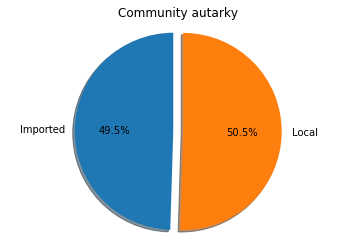

In [61]:

labels = 'Imported', 'Local'
sizes = [out_comm_final_p2p['grid2load'].sum()*param_tech_comm['timestep'], out_comm_final_p2p['inv2load'].sum()*param_tech_comm['timestep']]
explode = (0, 0.1)  # only "explode" the 2nd slice (i.e. 'Hogs')

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
ax1.set_title('Community autarky')
plt.show()

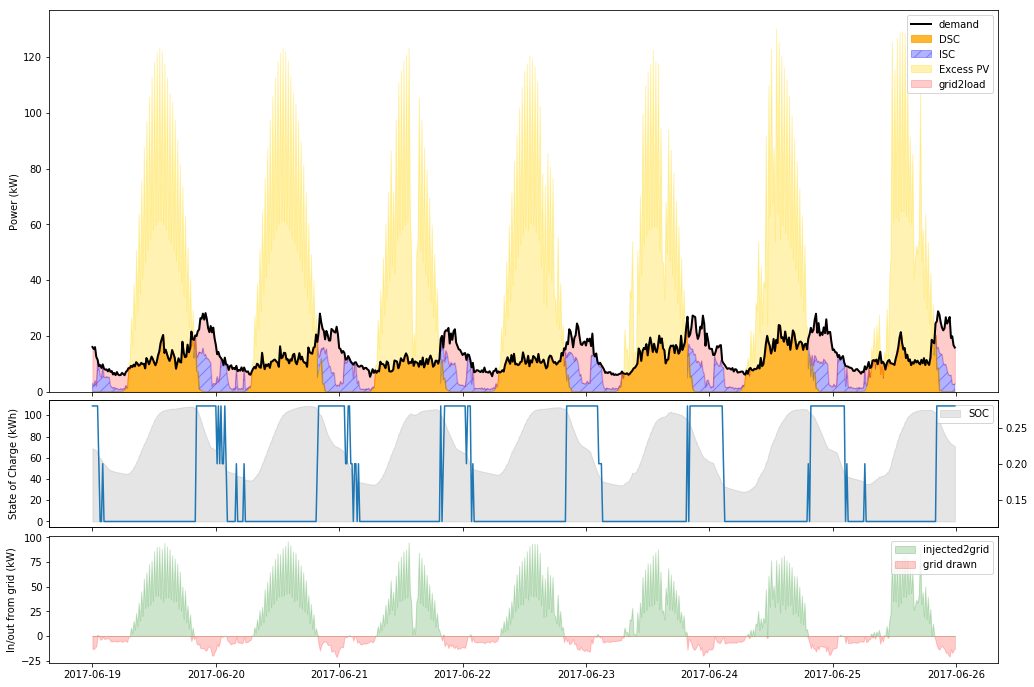

In [84]:
plot_dispatch_comm(df_CH_kW.E_PV*PV_size_comm, df_CH_kW.loc[:,df.iloc[:,0]].sum(axis=1),out_comm_final_p2p, week=25,flag=0,prices=df_prices)

In [63]:
#plot_dispatch_comm(df_CH_kW.E_PV*PV_size_comm, df_CH_kW.loc[:,df.iloc[:,0]].sum(axis=1),out_comm_final, week=1,flag=1)

Total yearly consumption: 2081.58 kWh
Total PV production: 6161.72 kWh
Self Consumption: 1197.97 kWh
Total fed to the grid: 4322.94 kWh
Total bought from the grid: 883.607 kWh
Self consumption rate (SCR): 19.4%
Self sufficiency rate (SSR): 57.6%
Amount of energy provided by the battery: 2758.85 kWh
Total battery losses: 272.853 kWh, i.e., 4.42819% of the total PV
Total energy from battery to the grid 2205.71 kWh
Total inverter losses: 352.399 kWh, i.e., 5.71916% of the total PV
Total curtailment : 15.5546 kWh
Residue (check): -1.85629e-12 kWh
PV Residue (check): -1.11733e-12 kWh
Maximum power injected into the grid is 4.4 kW
Maximum power drained from the grid is 3.84 kW
Total bill: 2993.97


Total Batt_revenue: 9898.05


Number of equivalent full cycles per year: 275.885 
Average Charging/Discharging depth: 0.755848




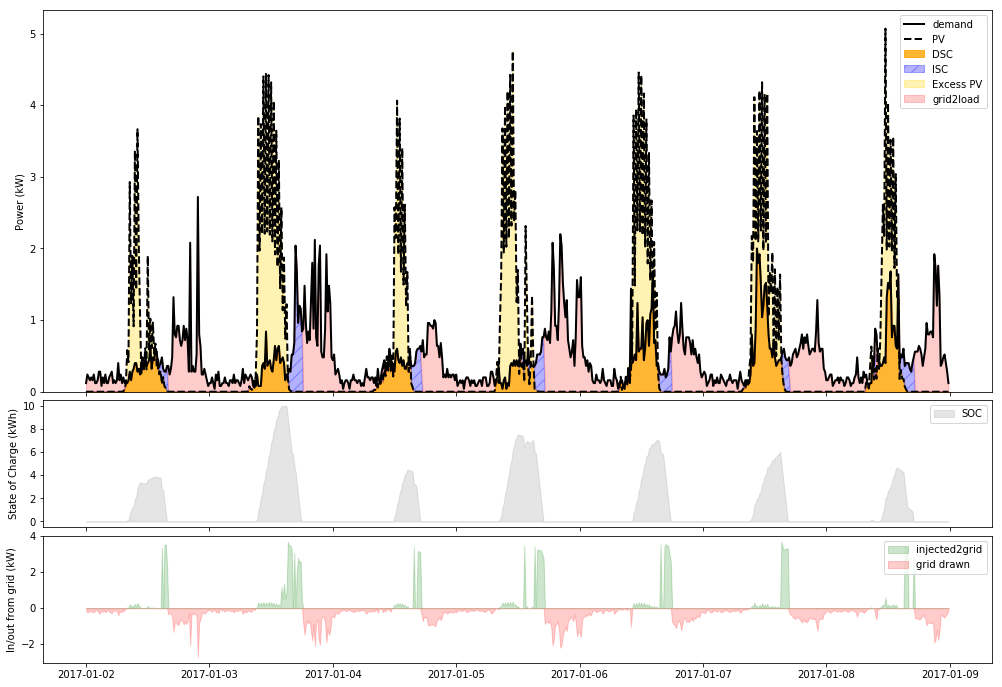

In [64]:
# Single household test
hhNumber=20
inv_size=max(param_tech['MaxPower'],selection.PV_size[hhNumber])#selection.PV_size[i]/ILR
out_aux=dispatch_max_sc_bhv(df_CH_kW.E_PV*selection.PV_size[hhNumber],df_CH_kW.loc[:,str(selection.name[hhNumber])],
                             df_bhv_paired[df_bhv_paired.id==selection.name[hhNumber]],prices_binned,inv_size,param_tech)

out_aux.keys()

(out_aux['pv2store']-out_aux['store2inv']).sum()*timestep

selection.PV_size[hhNumber]

print_analysis_prices(df_CH_kW.E_PV*selection.PV_size[hhNumber],df_CH_kW.loc[:,str(selection.name[hhNumber])],prices_binned,export_price_sc,param_tech,out_aux)

plot_dispatch(df_CH_kW.E_PV*selection.PV_size[hhNumber],df_CH_kW.loc[:,str(selection.name[hhNumber])],out_aux,week=1)

# ------------------------------------------------------------------------------

# Preliminary results:
## Going from a community without P2P to a community with P2P (and bhv) produces the following changes:
### In-house:

1. P2P decreases in-house SC and SS
2. Increases amount of import from the grid (bill)
3. Increases losses from battery and inverter
4. Increases the use of battery, EFC per year and average DoD
5. Decreases the PV curtailed

### Community-wise:

1. P2P slightly increases community SC (3%) and SS (4%)
2. Decreases total PV curtailed (~600 kWh p.a.)
3. Slightly decreases peak flow (3 kW)
4. Decreases total amount of energy bought from the grid (~5.4 MWh p.a.)


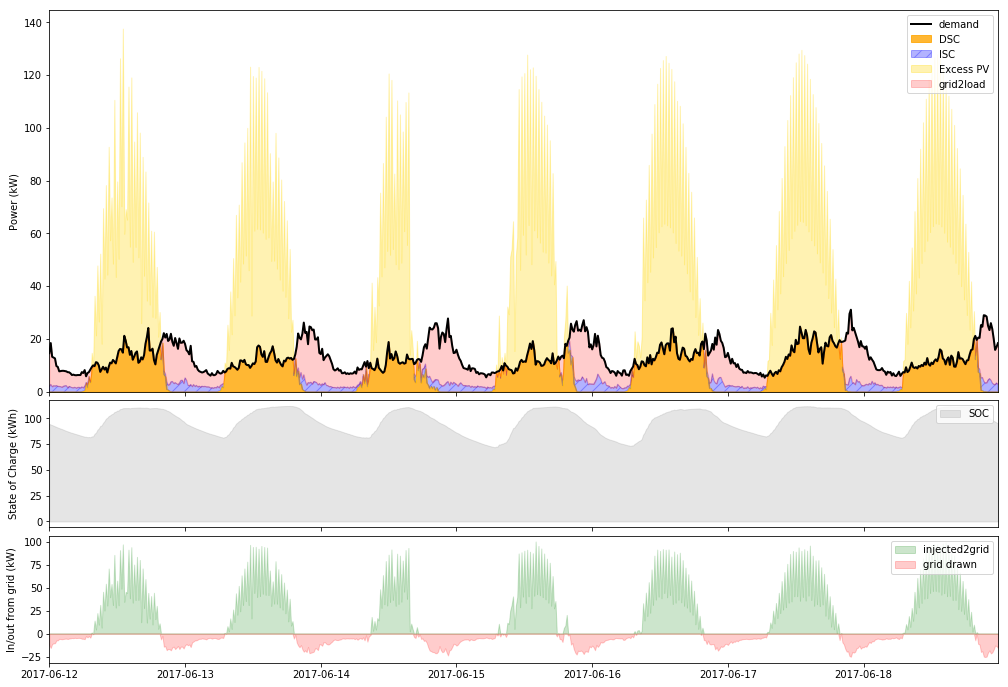

In [116]:
plot_dispatch_comm(df_CH_kW.E_PV*PV_size_comm, df_CH_kW.loc[:,df.iloc[:,0]].sum(axis=1),out_comm_final, week=24,flag=0)

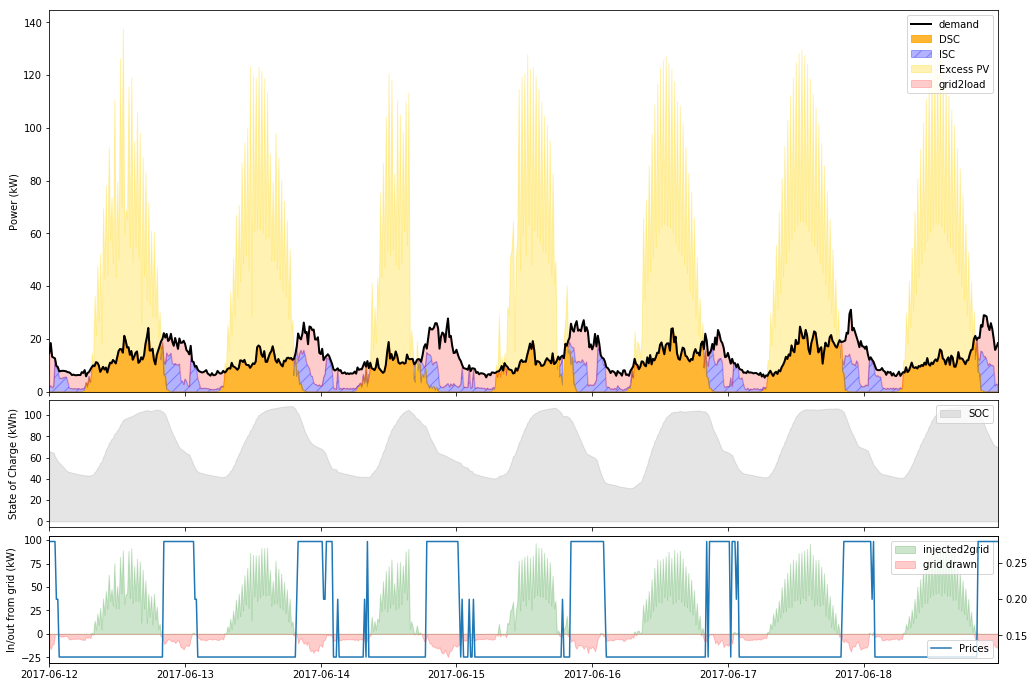

In [119]:
plot_dispatch_comm(df_CH_kW.E_PV*PV_size_comm, df_CH_kW.loc[:,df.iloc[:,0]].sum(axis=1),out_comm_final_p2p, week=24,flag=0,prices=df_prices)

In [67]:
residual=df_CH_kW.loc[:,df.iloc[:,0]].sum(axis=1)-df_CH_kW.E_PV*PV_size_comm*0.95
residual[residual<0]=0
comm_demand=df_CH_kW.loc[:,df.iloc[:,0]].sum(axis=1)

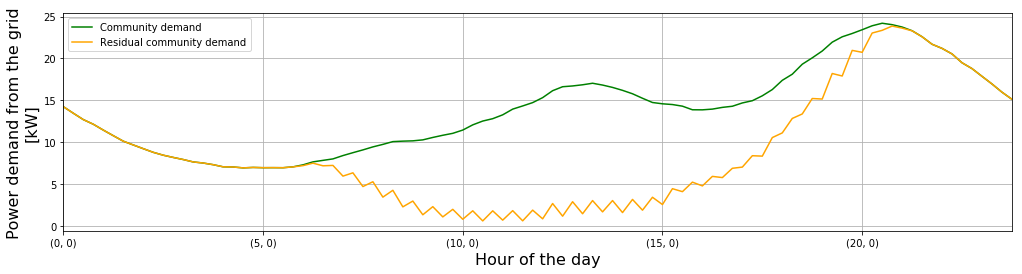

In [68]:
fig,ax=plt.subplots(nrows=1, ncols=1, sharex=True, figsize=(17, 4), frameon=False,
                             gridspec_kw={'height_ratios': [3], 'hspace': 0.04})

comm_demand.groupby([comm_demand.index.hour,comm_demand.index.minute]).mean().plot(color='green',label='Community demand')
residual.groupby([residual.index.hour,residual.index.minute]).mean().plot(color='orange',label='Residual community demand')
ax.set_xlabel('Hour of the day',size=16)
ax.set_ylabel('Power demand from the grid\n[kW]',size=16)
ax.grid()
plt.legend()

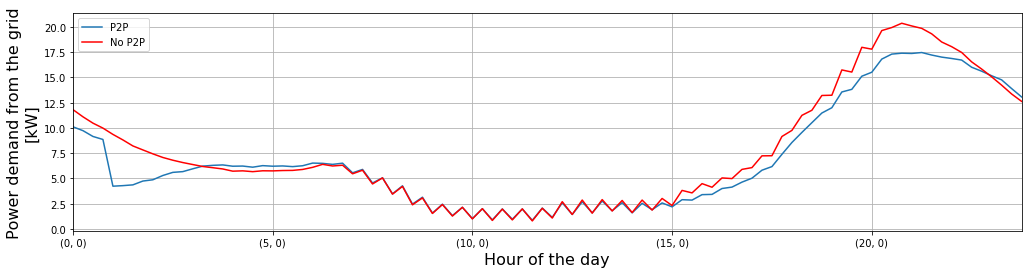

In [69]:
fig,ax=plt.subplots(nrows=1, ncols=1, sharex=True, figsize=(17, 4), frameon=False,
                             gridspec_kw={'height_ratios': [3], 'hspace': 0.04})
out_comm_final_p2p['grid2load'].groupby([out_comm_final_p2p['grid2load'].index.hour,
                                         out_comm_final_p2p['grid2load'].index.minute]).mean().plot(label='P2P')
out_comm_final['grid2load'].groupby([out_comm_final['grid2load'].index.hour,
                                     out_comm_final['grid2load'].index.minute]).mean().plot(color='red',label='No P2P')

ax.set_xlabel('Hour of the day',size=16)
ax.set_ylabel('Power demand from the grid\n[kW]',size=16)
ax.grid()
plt.legend()

In [70]:
out_comm_final_p2p['grid2load'].max()

41.440000000000005

In [73]:
print_analysis_prices(df_CH_kW.E_PV*PV_size_comm, df_CH_kW.loc[:,df.iloc[:,0]].sum(axis=1),retail_price_sc,export_price_sc,
                      param_tech_comm,out_comm_final,isCommunity=True)

Total yearly consumption: 121732 kWh
Total PV production: 155303 kWh
Self Consumption: 55008 kWh
Total fed to the grid: 88744.8 kWh
Total bought from the grid: 66724.2 kWh
Self consumption rate (SCR): 35.4%
Self sufficiency rate (SSR): 45.2%
Amount of energy provided by the battery: 13048.7 kWh
Total battery losses: 1292.76 kWh, i.e., 0.832407% of the total PV
Total energy from battery to the grid 0 kWh
Total inverter losses: 9175.71 kWh, i.e., 5.90825% of the total PV
Total curtailment : 1059.62 kWh
Residue (check): 3.48876e-11 kWh
PV Residue (check): 2.21547e-11 kWh
Maximum power injected into the grid is 102.439 kW
Maximum power drained from the grid is 41.28 kW
Total bill: 15800.2


Total Batt_revenue: 3209.56




{'SCR': 35.419697388282685,
 'SSR': 45.18769930388288,
 'EFC': None,
 'Demand_peak': 41.28,
 'Inj_peak': 102.4390038106203,
 'avg_dod': None,
 'bill': 15800.237324018732,
 'Batt_revenue': 3209.560863425691,
 'Batt_penetration': 50,
 'PV_penetration': 50,
 'seed': 1,
 'hh': None}

In [72]:
print_analysis_prices(df_CH_kW.E_PV*PV_size_comm,df_CH_kW.loc[:,df.iloc[:,0]].sum(axis=1),retail_price_sc,
                      export_price_sc,param_tech_comm,out_comm_final_p2p,isCommunity=True)

Total yearly consumption: 121732 kWh
Total PV production: 155303 kWh
Self Consumption: 61459.6 kWh
Total fed to the grid: 81658.5 kWh
Total bought from the grid: 60272.6 kWh
Self consumption rate (SCR): 39.6%
Self sufficiency rate (SSR): 50.5%
Amount of energy provided by the battery: 20587.4 kWh
Total battery losses: 2037.97 kWh, i.e., 1.31225% of the total PV
Total energy from battery to the grid 10158.2 kWh
Total inverter losses: 9135.2 kWh, i.e., 5.88216% of the total PV
Total curtailment : 993.485 kWh
Residue (check): -9.52483e-12 kWh
PV Residue (check): 2.3217e-11 kWh
Maximum power injected into the grid is 98.9549 kW
Maximum power drained from the grid is 41.44 kW
Total bill: 14212.7


Total Batt_revenue: 5064.59




{'SCR': 39.573914803168016,
 'SSR': 50.48756184446156,
 'EFC': None,
 'Demand_peak': 41.440000000000005,
 'Inj_peak': 98.95494063771737,
 'avg_dod': None,
 'bill': 14212.715293976977,
 'Batt_revenue': 5064.594632686178,
 'Batt_penetration': 50,
 'PV_penetration': 50,
 'seed': 1,
 'hh': None}

In [ ]:
98.9-72

In [ ]:
1268.96/485.442